## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split

In [2]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})
get_custom_objects().update({'srelu': pugna.activations.sReLU})

## Generate target waveform

1.1785016498623269 1.2246467991473532e-16 -0.0


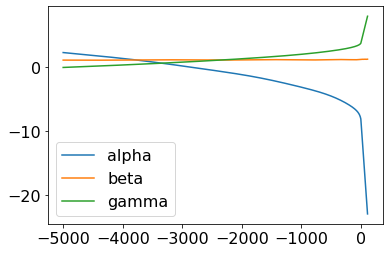

In [591]:
params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=0.99,
    S1y=0.,
    S2x=0.99,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

t_min=-5000
# t_min=-1000
times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=t_min, t_max=110)


thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

# wr.from_coprecessing_frame_to_inertial_frame()

Text(0.5, 0, 't [M]')

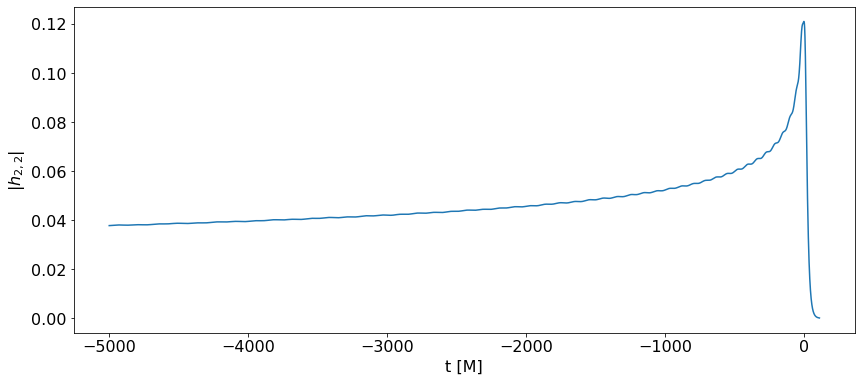

In [592]:
plt.figure(figsize=(14, 6))
plt.plot(times, np.abs(wr.hlms[(2,2)]))

plt.ylabel(r"$|h_{2,2}|$")
plt.xlabel("t [M]")

## feature engineering

In [593]:
# scale times
# times_scaler = MinMaxScaler(feature_range=(-1,0))
times_scaler = MinMaxScaler(feature_range=(0,1))
# times_scaler = MinMaxScaler(feature_range=(-1,1))
# times_scaler = MinMaxScaler(feature_range=(-0.1, 0.1))
# times_scaler = StandardScaler()
X_train = times_scaler.fit_transform(times[:,np.newaxis])

In [594]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
y_train = np.abs(wr.hlms[(2,2)])/scale_22
y_train = y_train[:, np.newaxis]

y_train = np.abs(wr.hlms[(2,2)])[:,np.newaxis]

0.12100846477960849


In [595]:
# scale_22 = np.real(wr.hlms[(2,2)]).max()
# print(scale_22)
# y_train = np.real(wr.hlms[(2,2)])/scale_22
# y_train = y_train[:, np.newaxis]

# y_train = np.real(wr.hlms[(2,2)])[:,np.newaxis]

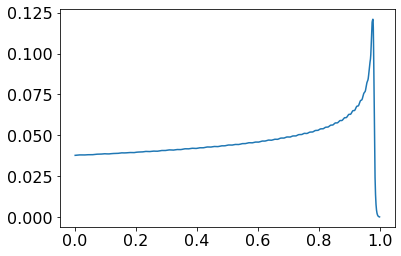

In [596]:
plt.plot(X_train, y_train)

## Multi-scale network fit

In [597]:
def make_shift_tensor(input_shape, shift, dtype=None):
    shifts = np.ones(shape=(input_shape,), dtype=dtype)
    shifts *= shift
    return shifts



class ShiftLayer(tf.keras.layers.Layer):
    def __init__(self, shift_tensor, **kwargs):
        super(ShiftLayer, self).__init__()
        self.shift_tensor = shift_tensor

    def call(self, inputs):
        return tf.math.add(inputs, self.shift_tensor)

    def get_config(self):
        config = super(ShiftLayer, self).get_config()
        config.update({"shift_tensor": self.shift_tensor})
        return config



In [598]:
make_shift_tensor(1, -3)

array([-3.])

In [599]:
def build_subnetwork(input_tensor, output_shape, units, activation, layers_per_block, output_name):
    x = input_tensor
    for _ in range(layers_per_block):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        
    x = tf.keras.layers.Dense(output_shape, activation="linear", name=output_name)(x)
    return x


In [600]:
from wispy.mscalev3 import make_scale_tensor, ScaleLayer

In [601]:
def build_model(input_shape=1, output_shape=1, shifts=[-1,0,1], scales=[1,10,50,100], units=128, scale_activation='s2relu', activation='relu', layers_per_block=3, final_dense=False):
    input_layer = tf.keras.Input(shape=(input_shape,))
    
    # create sub-networks
    
    counter=0
    xs = []
    for i, shift in enumerate(shifts):
        shift_tensor = make_shift_tensor(
            input_shape, shift, dtype=None
        )
        shifted_input = ShiftLayer(shift_tensor)(input_layer)
        # adding a dense layer seems to produce noisey outputs... not 100% sure though. only done a few tests.
#         shifted_input = tf.keras.layers.Dense(units, activation="linear")(
#             shifted_input
#         )
        for j, scale in enumerate(scales):
            scale_tensor = make_scale_tensor(
                input_shape, 0, scale, dtype=None
            )
            scaled_input = ScaleLayer(scale_tensor)(shifted_input)
            scaled_input = tf.keras.layers.Dense(units, activation=scale_activation)(
                scaled_input
            )
            counter+=1
#             print(counter)
            xs.append(build_subnetwork(input_tensor=scaled_input, output_shape=output_shape, units=units, activation=activation, layers_per_block=layers_per_block, output_name=f"outputs_{counter}"))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    if final_dense:
        output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model


In [602]:
# model = build_model(shifts=[-1,-0.75,-0.25,0,0.25,0.75,1], scales=[1,10,100], units=32, layers_per_block=1)

In [603]:
# model.summary()

In [604]:
# tf.keras.utils.plot_model(model)

In [727]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None):


#     model = build_model()
#     model = build_model(shifts=[0], scales=[1,10,100], units=128, layers_per_block=3)
#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3)
#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3, activation='tanh')
#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3, activation='s2relu')

#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3, activation='relu')
#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3, activation='srelu')


#     model = build_model(shifts=[0,-0.5,-1], scales=[1,10,100], units=128, layers_per_block=3, activation='elu')
#     model = build_model(shifts=[0,-0.5,-1], scales=[1,10,100], units=256, layers_per_block=2, activation='relu')
#     model = build_model(shifts=[0,-1], scales=[1,10,100], units=256, layers_per_block=2, activation='relu')
#     model = build_model(shifts=[0,1], scales=[1,10,100], units=128, layers_per_block=2, activation='srelu')


#     model = build_model(shifts=[0,-0.5,-0.9], scales=[1], units=128, layers_per_block=2, activation='relu', scale_activation='relu')
#     model = build_model(shifts=[0,-0.9], scales=[1,10,100], units=128, layers_per_block=2, activation='srelu')
#     model = build_model(shifts=[0,-0.9], scales=[1,10,100], units=128, layers_per_block=2, activation='relu')
#     model = build_model(shifts=[0,-0.9], scales=[1,10], units=128, layers_per_block=2, activation='relu')
    model = build_model(shifts=[0,-0.9], scales=[1,10,50], units=128, layers_per_block=2, activation='relu')
#     model = build_model(shifts=[0,-0.5,-1], scales=[1,10,100], units=128, layers_per_block=3, activation='srelu')
    
#     model = build_model(shifts=[-1,0,1], scales=[1,10,100], units=128, layers_per_block=3, final_dense=True)
#     model = build_model(shifts=[-1,-0.75,-0.25,0,0.25,0.75,1], scales=[1,10,100], units=128, layers_per_block=3)
#     model = build_model(shifts=[-1,-0.95,-0.75,-0.25,0,0.25,0.75,1], scales=[1,10], units=128, layers_per_block=2)
#     model = build_model(shifts=[-1,-0.95,-0.75,-0.25,0,0.25,0.75,1], scales=[1,10,100], units=128, layers_per_block=3, activation='srelu')
    
    
#     def scheduler(epoch, lr):
#         if epoch <= 400:
#             return 1e-3
#         else:
#             return 1e-4
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')
#         tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.1, monitor='loss')
#         tf.keras.callbacks.LearningRateScheduler(scheduler)
#         tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=100, factor=0.9, monitor='loss')
    ]
    
#     lr=tfa.optimizers.TriangularCyclicalLearningRate(initial_learning_rate=1e-4, maximal_learning_rate=1e-2, step_size=2000, scale_mode="cycle")
    lr=1e-3
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr))
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [728]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [729]:
X_train.shape

(11340, 1)

In [730]:
%%time
epochs=5000
# epochs=1000
# epochs=2000
history, model = run_model(X_train_fit, y_train_fit, epochs=epochs, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit), threshold=1e-9)

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 24min 49s, sys: 9min 48s, total: 34min 38s
Wall time: 7min 15s


In [731]:
history.history['loss'][-1]

9.902747510892596e-10

In [732]:
model.summary()

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
shift_layer_97 (ShiftLayer)     (None, 1)            0           input_44[0][0]                   
__________________________________________________________________________________________________
shift_layer_98 (ShiftLayer)     (None, 1)            0           input_44[0][0]                   
__________________________________________________________________________________________________
scale_layer_275 (ScaleLayer)    (None, 1)            0           shift_layer_97[0][0]             
___________________________________________________________________________________________

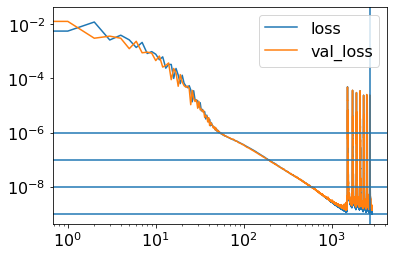

In [733]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.axhline(1e-6)
plt.axhline(1e-7)
plt.axhline(1e-8)
plt.axhline(1e-9)

plt.axvline(2716)

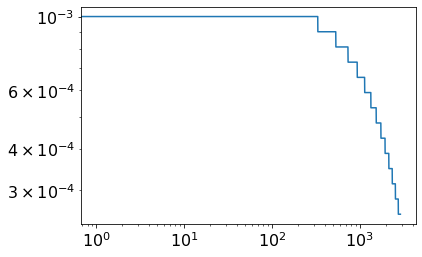

In [734]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [735]:
yhat = model.predict(X_train)

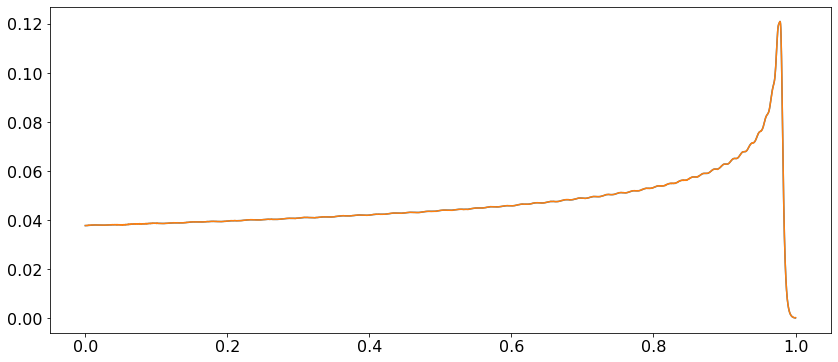

In [736]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
# plt.xlim(0, 1.1)
# plt.yscale('log')

(0.7, 1.1)

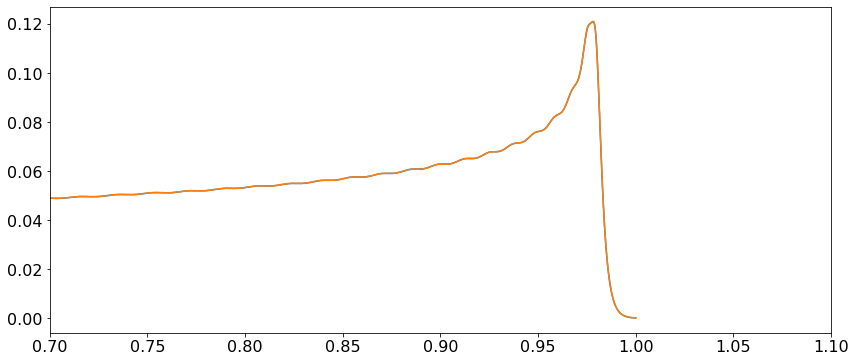

In [737]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
plt.xlim(0.7, 1.1)
# plt.yscale('log')

(0.9, 1.1)

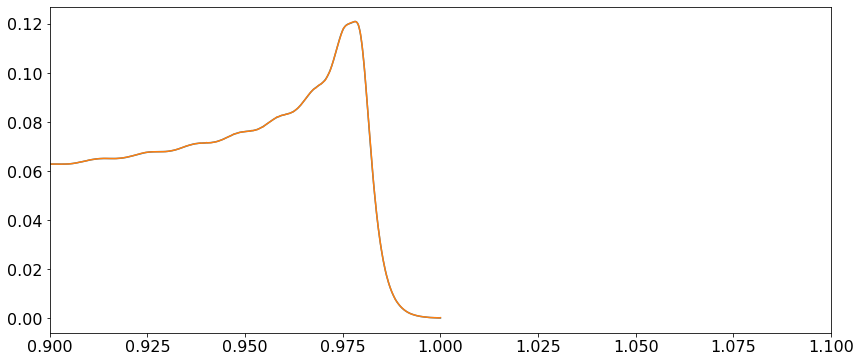

In [738]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
plt.xlim(0.9, 1.1)
# plt.yscale('log')

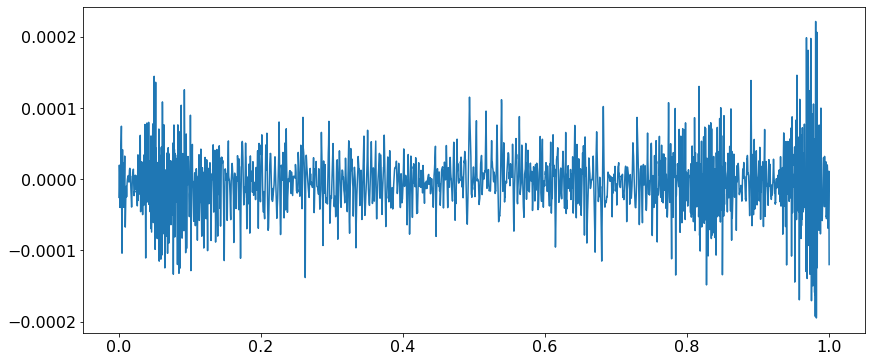

In [739]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, y_train[:,0]-yhat[:,0])
# plt.xlim(0, 1.1)
# plt.yscale('log')

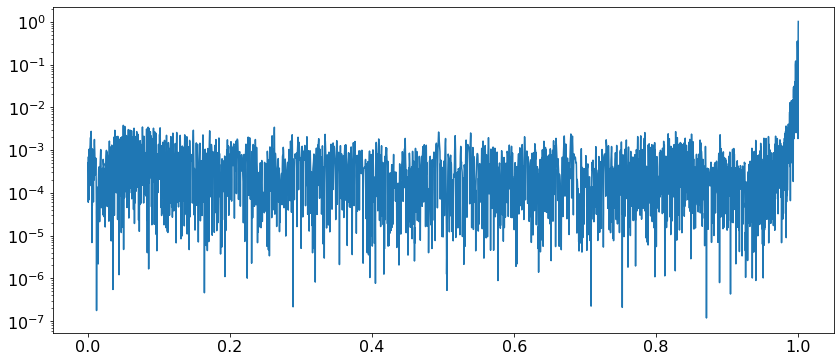

In [740]:
plt.figure(figsize=(14, 6))
plt.plot(X_train, np.abs(y_train[:,0]-yhat[:,0])/y_train[:,0])
# plt.xlim(0, 1.1)
plt.yscale('log')

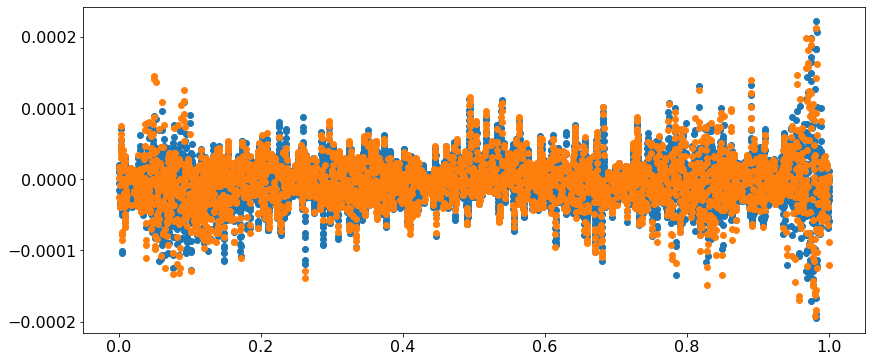

In [741]:
yhat = model.predict(X_train_fit)
yhat_test = model.predict(X_test_fit)
plt.figure(figsize=(14, 6))
plt.scatter(X_train_fit, y_train_fit[:,0]-yhat[:,0])
plt.scatter(X_test_fit, y_test_fit[:,0]-yhat_test[:,0])
# plt.scatter(X_train_fit, yhat[:,0])
# plt.xlim(0, 1.1)
# plt.yscale('log')